In [ ]:
  #importing libraries
import pandas as pd
import numpy as np

#for text_preprocessing.
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#tensorflow libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfd

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Loading Dataset

In [ ]:
crime=pd.read_csv('/content/drive/MyDrive/GROUP 2/CSVfiles2/crime-k.csv')

# Checking Datasets.

In [ ]:
#preview shape.
crime.shape

(3000, 12)

In [ ]:
crime.head(2)

,Unnamed: 0,user,tweet,location,description,friends_count,followers_count,statuses_count,created_at,retweet_count,hashtags,label
0,0,MuchangiNyaga5,@MathareSJustice @wanjirunjira @UhaiWetu @gach...,"Nairobi, Kenya",NaN,37,0,2,8/17/2021 8:59,0,[],police brutality
1,1,jmkariuki24,It is not easy being a young person in this co...,"Nairobi, Kenya",Evidence enthusiast with a passion for advanci...,8979,12175,276,8/17/2021 8:52,0,[],police brutality


In [ ]:
#preview columns
crime.columns

Index(['Unnamed: 0', 'user', 'tweet', 'location', 'description',
       'friends_count', 'followers_count', 'statuses_count', 'created_at',
       'retweet_count', 'hashtags', 'label'],
      dtype='object')

In [ ]:
#drop unnecessary columns
crime.drop(['Unnamed: 0', 'friends_count', 'followers_count', 'statuses_count', 'retweet_count','description','hashtags'], axis=1, inplace=True)

In [ ]:
#checking the shape after dropping the columns
crime.shape

(3000, 5)

In [ ]:
crime.head()

,user,tweet,location,created_at,label
0,MuchangiNyaga5,@MathareSJustice @wanjirunjira @UhaiWetu @gach...,"Nairobi, Kenya",8/17/2021 8:59,police brutality
1,jmkariuki24,It is not easy being a young person in this co...,"Nairobi, Kenya",8/17/2021 8:52,police brutality
2,FlavionsKimani,"You come to voters begging for votes, yet none...",Nairobi Kenya,8/17/2021 8:48,police brutality
3,nyamu_dickson,It would be wise if we have bloggers with cont...,"Nairobi, Kenya",8/17/2021 7:45,police brutality
4,prings_ke,"Before you vote, ask your candidates what they...","Thika, Kenya",8/17/2021 7:44,police brutality


In [ ]:
crime.to_csv('crimecl.csv',index=False)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
crime.duplicated().sum()

0

In [ ]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

crime['clean_tweet']=crime['tweet'].apply(lambda x : preprocess(x))

In [ ]:
#stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

crime['clean_tweet']=crime['clean_tweet'].apply(lambda x : stopword(x))  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#wordnetlemmatizer
from nltk.stem import WordNetLemmatizer
w = WordNetLemmatizer()

In [ ]:
#Wordnet Lemmatization and POS Tagging 
#parts of speech(POS)
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
#defining lemmatization function

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) 
    a=[w.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a) 

def final(string):
    return lemmatizer(string)
crime['clean_tweet']= crime['clean_tweet'].apply(lambda x: final(x))
crime.head()

,user,tweet,location,created_at,label,clean_tweet
0,MuchangiNyaga5,@MathareSJustice @wanjirunjira @UhaiWetu @gach...,"Nairobi, Kenya",8/17/2021 8:59,police brutality,matharesjustice wanjirunjira uhaiwetu gacheke ...
1,jmkariuki24,It is not easy being a young person in this co...,"Nairobi, Kenya",8/17/2021 8:52,police brutality,easy young person country survive kcse kuccps ...
2,FlavionsKimani,"You come to voters begging for votes, yet none...",Nairobi Kenya,8/17/2021 8:48,police brutality,come voter beg vote yet none ya politician con...
3,nyamu_dickson,It would be wise if we have bloggers with cont...,"Nairobi, Kenya",8/17/2021 7:45,police brutality,would wise blogger content drive agenda succes...
4,prings_ke,"Before you vote, ask your candidates what they...","Thika, Kenya",8/17/2021 7:44,police brutality,vote ask candidate police brutality take time ...


In [ ]:
#label encoding our label
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
crime['label']=le.fit_transform(crime['label'])

In [ ]:
#splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(crime["clean_tweet"], 
                                                  crime['label'],
                                                  test_size=0.33,
                                                  shuffle=True)

In [ ]:
X_train.shape,y_train.shape

((2010,), (2010,))

In [ ]:
#vectorization
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, )
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'tweets')

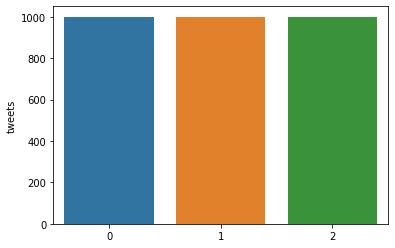

In [ ]:
#check for class imbalance
import matplotlib.pyplot as plt

import seaborn as sns
x=crime.label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('tweets')

## KNN

In [ ]:
#we are going to use k of 5
from sklearn.neighbors import KNeighborsClassifier
cl=KNeighborsClassifier(n_neighbors=5)
cl.fit(X_train_tfidf,y_train)
#we will predict our model
y_pred =cl.predict(X_val_tfidf)

In [ ]:
#checking metrics for accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(np.mean(y_pred == y_val))

[[266  25  52]
 [ 41 218  74]
 [ 25  37 252]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       343
           1       0.78      0.65      0.71       333
           2       0.67      0.80      0.73       314

    accuracy                           0.74       990
   macro avg       0.75      0.74      0.74       990
weighted avg       0.75      0.74      0.74       990

0.7434343434343434


Accuracy of 76% 

In [ ]:
#we will tune our parameter using gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsClassifier()

cl_g = GridSearchCV(knn, params, cv=5)
cl_g.fit(X_train_tfidf,y_train)
cl_g.best_params_
#the best parameter for our model is 9

{'n_neighbors': 8}

In [ ]:
#training our model using k as 9

from sklearn.neighbors import KNeighborsClassifier
cl_gs=KNeighborsClassifier(n_neighbors=9)
cl_gs.fit(X_train_tfidf,y_train)

#predicting our model
y_pred_gs=cl_gs.predict(X_val_tfidf)

In [ ]:
#checking metrics for our models accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred_gs))
print(classification_report(y_val, y_pred_gs))
print(np.mean(y_pred_gs == y_val))

[[279  22  42]
 [ 31 222  80]
 [ 20  25 269]]
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       343
           1       0.83      0.67      0.74       333
           2       0.69      0.86      0.76       314

    accuracy                           0.78       990
   macro avg       0.79      0.78      0.78       990
weighted avg       0.79      0.78      0.78       990

0.7777777777777778


got an accuracy of 78% after tuning the parameters for our model.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)
#fitting our model
classifier_rf.fit(X_train_tfidf, y_train)

#predicting our model
y_pred_rf= classifier_rf.predict(X_val_tfidf)

In [ ]:
#checking metrics for our models accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))
print(np.mean(y_pred_rf == y_val))

[[318   6  19]
 [ 45 254  34]
 [ 30  11 273]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       343
           1       0.94      0.76      0.84       333
           2       0.84      0.87      0.85       314

    accuracy                           0.85       990
   macro avg       0.86      0.85      0.85       990
weighted avg       0.86      0.85      0.85       990

0.8535353535353535


Random forest 84% accuracy.

In [ ]:
 test_features=crime['label']

In [ ]:
from pprint import pprint
pprint(classifier_rf.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)>


#### Gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.3min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [ ]:
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# import pydotplus

# dot_data = StringIO()
# # pick a specific tree from the forest
# tree = classifier_rf.estimators_[50]

# export_graphviz(tree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = test_features)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('absenteism_forest.png')
# Image(graph.create_png())


## Adaboost

In [ ]:
#Adaboost 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_boost = AdaBoostClassifier( DecisionTreeClassifier(max_depth=4),
                          n_estimators=300, random_state=0)

#training our dataset
ada_boost = ada_boost.fit(X_train_tfidf, y_train)

#predicting 
y_pred_ada = ada_boost.predict(X_val_tfidf)

In [ ]:
#checking metrics for our models accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred_ada))
print(classification_report(y_val, y_pred_ada))
print(np.mean(y_pred_ada == y_val))

[[294  34  15]
 [ 33 271  29]
 [ 24  44 246]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       343
           1       0.78      0.81      0.79       333
           2       0.85      0.78      0.81       314

    accuracy                           0.82       990
   macro avg       0.82      0.82      0.82       990
weighted avg       0.82      0.82      0.82       990

0.8191919191919191


83% accuracy with adaboost

## GradientBoostClassifier

In [ ]:
#Gradientboost Classifier.
from sklearn.ensemble import GradientBoostingClassifier


gbr = GradientBoostingClassifier(n_estimators=200, learning_rate=0.4, max_depth=2)

#training our model.
gbr = gbr.fit(X_train_tfidf, y_train)

#predicting.
y_pred_gbr = gbr.predict(X_val_tfidf)

In [ ]:
#checking metrics for our models accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred_gbr))
print(classification_report(y_val, y_pred_gbr))
print(np.mean(y_pred_gbr == y_val))

[[314  17  12]
 [ 33 266  34]
 [ 18  27 269]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       343
           1       0.86      0.80      0.83       333
           2       0.85      0.86      0.86       314

    accuracy                           0.86       990
   macro avg       0.86      0.86      0.86       990
weighted avg       0.86      0.86      0.86       990

0.8575757575757575


Graadientboost with 83% accuracy.

## Logistic Regression

In [ ]:
#logistic regression

from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
#fitting our model
lr.fit(X_train_tfidf, y_train) 

#Predict y value for test dataset
y_predict = lr.predict(X_val_tfidf)

 

In [ ]:
#checking metrics for our models accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_predict))
print(classification_report(y_val,y_predict))
print(np.mean(y_predict == y_val))

[[318  12  13]
 [ 27 274  32]
 [ 14  23 277]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       343
           1       0.89      0.82      0.85       333
           2       0.86      0.88      0.87       314

    accuracy                           0.88       990
   macro avg       0.88      0.88      0.88       990
weighted avg       0.88      0.88      0.88       990

0.8777777777777778


accuracy 88%

## X_gboost

In [ ]:
%%capture
!pip install xgboost
!pip install --upgrade xgboost

In [ ]:
#X_gboost model.
from xgboost import XGBClassifier
model = XGBClassifier()

#training our model
model.fit(X_train_tfidf, y_train)

#predicting
y_predX = model.predict(X_val_tfidf)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:45:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#checking metrics for our models accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_predX))
print(classification_report(y_val,y_predX))
print(np.mean(y_predX == y_val))

[[317  15  11]
 [ 33 267  33]
 [ 24  31 259]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       343
           1       0.85      0.80      0.83       333
           2       0.85      0.82      0.84       314

    accuracy                           0.85       990
   macro avg       0.85      0.85      0.85       990
weighted avg       0.85      0.85      0.85       990

0.8515151515151516


With X_gboost accuracy of 85%

## Support Vector Classifier

In [ ]:
#Support vector Classification
from sklearn.svm import SVC,LinearSVC
# Fitting  the model
svm = SVC(kernel= 'linear')
svm.fit(X_train_tfidf, y_train)

#predicting
y_pred_svm = svm.predict(X_val_tfidf)

In [ ]:
#checking metrics for our models accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val,y_pred_svm))
print(classification_report(y_val,y_pred_svm))
print(np.mean(y_pred_svm  == y_val))

[[322  10  11]
 [ 30 274  29]
 [ 12  23 279]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       343
           1       0.89      0.82      0.86       333
           2       0.87      0.89      0.88       314

    accuracy                           0.88       990
   macro avg       0.88      0.88      0.88       990
weighted avg       0.88      0.88      0.88       990

0.8838383838383839


88% percentage accuracy.

## Naive bayes

In [ ]:
#Naive bayes Multinomial.
# Training our model
from sklearn.naive_bayes import MultinomialNB  
mn= MultinomialNB().fit(X_train_tfidf, y_train)

# Predicting our test predictors
y_pred_mn = mn.predict(X_val_tfidf)

In [ ]:
#checking metrics for our models accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val,y_pred_mn ))
print(classification_report(y_val,y_pred_mn ))
print(np.mean(y_pred_mn  == y_val))

[[303  16  24]
 [ 26 242  65]
 [  9  26 279]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       343
           1       0.85      0.73      0.78       333
           2       0.76      0.89      0.82       314

    accuracy                           0.83       990
   macro avg       0.84      0.83      0.83       990
weighted avg       0.84      0.83      0.83       990

0.8323232323232324
